In [1]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
import matplotlib.image as mpimg
import os

In [2]:
walk_through_dir('data')

There are 3 directories and 0 images in 'data'.
There are 10 directories and 0 images in 'data\test'.
There are 0 directories and 212 images in 'data\test\butterfly'.
There are 0 directories and 168 images in 'data\test\cat'.
There are 0 directories and 311 images in 'data\test\chicken'.
There are 0 directories and 188 images in 'data\test\cow'.
There are 0 directories and 487 images in 'data\test\dog'.
There are 0 directories and 146 images in 'data\test\elephant'.
There are 0 directories and 263 images in 'data\test\horse'.
There are 0 directories and 483 images in 'data\test\ragno'.
There are 0 directories and 182 images in 'data\test\sheep'.
There are 0 directories and 187 images in 'data\test\squirrel'.
There are 10 directories and 0 images in 'data\train'.
There are 0 directories and 1689 images in 'data\train\butterfly'.
There are 0 directories and 1334 images in 'data\train\cat'.
There are 0 directories and 2478 images in 'data\train\chicken'.
There are 0 directories and 1492 i

In [3]:
train_dir = r'./data/train'
test_dir = r'./data/test'
val_dir = r'./data/val'

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224, 224))

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               label_mode='categorical',
                                                               image_size=(224, 224))


Found 20938 files belonging to 10 classes.
Found 2627 files belonging to 10 classes.
Found 2627 files belonging to 10 classes.


In [4]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
])

In [5]:
def get_random_photo_2v(target_dir=train_dir, class_names = train_data.class_names):
    target_class = np.random.choice(class_names)
    path_to_target_class = target_dir + '/' + target_class
    random_image_name = np.random.choice(os.listdir(path_to_target_class))
    img_path = path_to_target_class + '/' + random_image_name
    
    print(img_path)
    
    img = mpimg.imread(img_path)
    plt.figure(figsize=(24, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis(False)
    plt.title(f'{target_class}')
    
    img_aug = data_augmentation(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_aug/255)
    plt.axis(False)
    plt.title(f'{target_class} -- augmented')
    

./data/train/horse/OIP-SrtJbq9KbmFcqJQOkLY5UwHaGz.jpeg


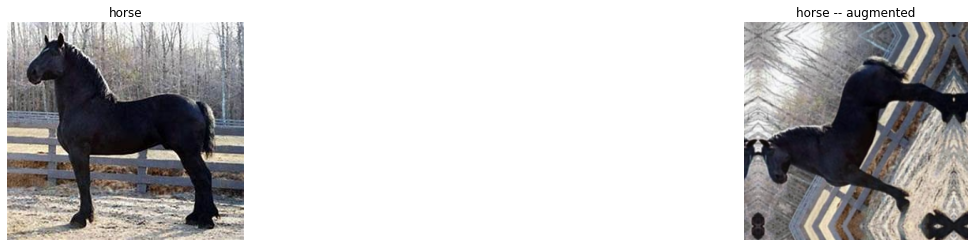

In [6]:
get_random_photo_2v()

## Modelling

In [7]:

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True



inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=int(0.25 * len(val_data)), 
                        callbacks=[create_tensorboard_callback('transfer_learning',
                                                              'Animals_10_EfficientNetB0')])

Saving TensorBoard log files to: transfer_learning/Animals_10_EfficientNetB0/20230320-115556
Epoch 1/5
655/655 [==============================] - 131s 129ms/step - loss: 1.0761 - accuracy: 0.7923 - val_loss: 0.4626 - val_accuracy: 0.9406
Epoch 2/5
655/655 [==============================] - 75s 114ms/step - loss: 0.3275 - accuracy: 0.9530 - val_loss: 0.2388 - val_accuracy: 0.9594
Epoch 3/5
655/655 [==============================] - 75s 114ms/step - loss: 0.2061 - accuracy: 0.9627 - val_loss: 0.1650 - val_accuracy: 0.9656
Epoch 4/5
655/655 [==============================] - 75s 115ms/step - loss: 0.1599 - accuracy: 0.9676 - val_loss: 0.1498 - val_accuracy: 0.9609
Epoch 5/5
655/655 [==============================] - 74s 113ms/step - loss: 0.1368 - accuracy: 0.9702 - val_loss: 0.1333 - val_accuracy: 0.9609


In [8]:
model_1.evaluate(test_data)

83/83 [==============================] - 10s 113ms/step - loss: 0.1138 - accuracy: 0.9711


[0.11384417116641998, 0.9710696339607239]

##### Prediction

In [17]:
def pred_and_plot(model, filename, class_names, scale):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename, scale=scale)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.figure(figsize=(8, 5))
    plt.imshow(img/255)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);



1/1 [==============================] - 0s 64ms/step


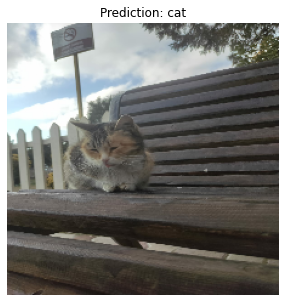

In [18]:
pred_and_plot(model_1, 'tofiq_cat.jpg', train_data.class_names, False)

In [13]:
train_data.class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'ragno',
 'sheep',
 'squirrel']

In [14]:
[(layer.name, layer.trainable) for layer in base_model.layers]

[('input_1', False),
 ('rescaling', False),
 ('normalization', False),
 ('tf.math.truediv', False),
 ('stem_conv_pad', False),
 ('stem_conv', False),
 ('stem_bn', False),
 ('stem_activation', False),
 ('block1a_dwconv', False),
 ('block1a_bn', False),
 ('block1a_activation', False),
 ('block1a_se_squeeze', False),
 ('block1a_se_reshape', False),
 ('block1a_se_reduce', False),
 ('block1a_se_expand', False),
 ('block1a_se_excite', False),
 ('block1a_project_conv', False),
 ('block1a_project_bn', False),
 ('block2a_expand_conv', False),
 ('block2a_expand_bn', False),
 ('block2a_expand_activation', False),
 ('block2a_dwconv_pad', False),
 ('block2a_dwconv', False),
 ('block2a_bn', False),
 ('block2a_activation', False),
 ('block2a_se_squeeze', False),
 ('block2a_se_reshape', False),
 ('block2a_se_reduce', False),
 ('block2a_se_expand', False),
 ('block2a_se_excite', False),
 ('block2a_project_conv', False),
 ('block2a_project_bn', False),
 ('block2b_expand_conv', False),
 ('block2b_expand_